# Residential Solar Panel Cost Prediction

Author: Sayantan Mitra<br>
Chief Data Scientist, Crompton & Wendler<br>
Ph.D. candidate, Baylor College of Medicine

# 1.A. Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

# VisualiZation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Data selected as discussed in Part_1 notebook for data exploration

In [2]:
solar = pd.read_csv('solar_costpred.csv', parse_dates=['date_installed']) 
# Selecting only residential setting
solar = solar[solar['install_type'] == 'residential']
# All residential so drop column 'install_type' # only keepin columns relevant to user input
solar = solar.drop(columns=['install_type', 'incentive_prog_names', 
                           'tracking_type', 'annual_insolation'])
solar.head()

,state,date_installed,zipcode,installer,cost,city,tech_1,county,annual_PV_prod
0,TX,2013-12-12,78702,NaN,30600.53,AUSTIN,Poly,Travis,14999.831600
1,TX,2014-07-11,78702,NaN,40000.00,AUSTIN,Mono,Travis,17811.574390
2,TX,2014-01-17,78702,NaN,22665.58,AUSTIN,Mono,Travis,7833.742822
3,TX,2012-09-27,78702,NaN,28125.00,AUSTIN,Poly,Travis,10151.709590
4,TX,2012-09-26,78702,NaN,19250.00,AUSTIN,Poly,Travis,7307.133789


■ We have done detailed EDA of every feature in `Part 1. SolarPanel_SizePrediction`. Only difference here is the target i.e. `cost of solar panels` instead of `size of solar panels`.

■ We will only perform EDA on `cost of solar panels` to check whether it needs transformation similar to `size of solar panels` in Part 2 to make it into a gaussian distribution.

■ As rest would be same, we will use ML Pipeline.

In [3]:
# missing values in the data
solar.isna().mean().round(3)

state             0.000
date_installed    0.000
zipcode           0.000
installer         0.127
cost              0.000
city              0.000
tech_1            0.220
county            0.000
annual_PV_prod    0.000
dtype: float64

Check whether the missing value might have any predictive power on cost of the solar panels 

In [4]:
a = solar.dropna()['cost'].median()
b = solar.loc[solar['installer'].isna(),['cost']].median()[0].round(2)
c = solar.loc[solar['tech_1'].isna(),['cost']].median()[0].round(2)

print(f'Overall solar panel cost in residential housing without missing values: {a}\n')
print(f'Overall solar panel cost in when installer data is missing: {b}\n')
print(f'Overall solar panel cost in when tech_1 data is missing: {c}\n')

Overall solar panel cost in residential housing without missing values: 27955.2

Overall solar panel cost in when installer data is missing: 30811.3

Overall solar panel cost in when tech_1 data is missing: 31080.0



# 1.B. Feature Engineering

In [5]:
# Zipcode: extract first number of zipcode 
solar['zipcode_1'] = solar['zipcode'].astype('str').str[:1]#.astype(int)
# DateTime column: extract year and month of installation
date = solar['date_installed']
solar['year'] =  date.dt.year.astype('str')

# Divide data into train and test # Use this test as a validation set later on
from sklearn.model_selection import train_test_split
solar_train, solar_val = train_test_split(solar, test_size=0.2, random_state= 0)
solar = solar_train
solar.shape, solar_val.shape

((390260, 11), (97566, 11))

**Reduce Cardinality** <br>

In [6]:
# Reduce cardinality as explained in the Part_1 notebook
def group_levels_in_categoricals(df, threshold=0.01, min_freq=0, max_freq=np.Inf):
    df0 = df.describe(include=['O']).T
    # reduced list is name of categorical columns
    reduced_list = df0[(df0.unique < max_freq) & (df0.unique > min_freq)].reset_index()['index'].tolist()
    
    #patterns will contain list of all categories of all categorical column whose occurance is more than threshold
    patterns = []
    other = []
    for col in reduced_list:
        df_normalized = df[col].value_counts(normalize=True).reset_index()
        df_normalized.columns = ['col_name', 'normalized_value']
        filt = df_normalized['normalized_value'] > threshold
        # norm_list contains all the categories in a categorical column whose occurance is more than threshold    
        norm_list = df_normalized[filt]['col_name'].tolist()
        pattern = norm_list
        patterns.append(norm_list)
        # selecting categories that are present less than threshold
        others_list = df_normalized[~filt]['col_name'].tolist()
        other.append(others_list)
        
        if pattern != []: 
            df[col] = df[col].replace({x:'Other' for x in others_list})
        else:
            df.drop(col, inplace=True, axis=1)
    return (df, patterns, reduced_list, other)

df, patterns, reduced_list, other = group_levels_in_categoricals(solar)
# solar training set after transformation
solar.describe(include=['O']).T

,count,unique,top,freq
state,390260,12,CA,209789
installer,340769,11,Other,179467
city,390260,7,Other,355358
tech_1,304531,5,Poly,176045
county,390260,22,Other,129721
zipcode_1,390260,7,9,211323
year,390260,10,2015,142228


In [7]:
# Keep this consistent with test data as well
def group_levels_in_categoricals_test(reduced_list, other, patterns, df_test):   
    for idx, col in enumerate(reduced_list):       
        if other[idx] != []:
            filt = df_test[col].isin(patterns[idx])
            df_test[col][~filt]='Others'
        else:
            df_test.drop(col, inplace=True, axis=1)       
    return df_test

solar_val = group_levels_in_categoricals_test(reduced_list, other, patterns, solar_val)
# solar validation set after transformation
solar_val.describe(include=['O']).T

,count,unique,top,freq
state,97566,12,CA,52467
installer,97566,11,Others,57506
city,97566,7,Others,88852
tech_1,97566,5,Poly,44050
county,97566,22,Others,32447
zipcode_1,97566,7,9,52849
year,97566,10,2015,35520


# 2.A. Explore target variable: `cost`

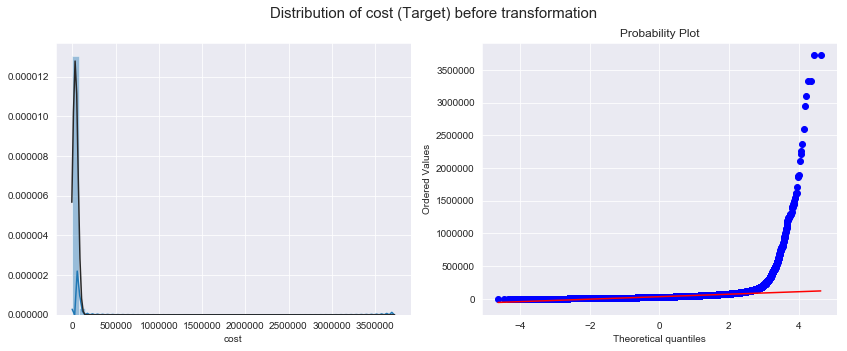

mu = 32855.44 and sigma = 31102.99

Skewness: 37.791336
Kurtosis: 2983.535844




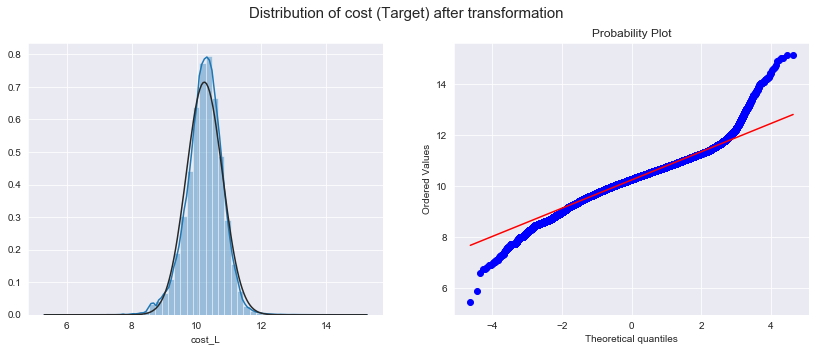


 mu = 10.24 and sigma = 0.56

Skewness: -0.213634
Kurtosis: 1.676708


In [8]:
import scipy.stats as st
from scipy.stats import norm, skew # for some statistics
fig, axes = plt.subplots(1,2, figsize = (14,5))

# Distribution of target
sns.distplot(solar['cost'], fit=norm, ax=axes[0])
# QQ-plot to check normality
res = st.probplot(solar['cost'], plot=plt)
fig.suptitle('Distribution of cost (Target) before transformation', size=15)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['cost'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['cost'].skew())
print("Kurtosis: %f" % solar['cost'].kurt())
print('\n')

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
solar['cost_L'] = np.log1p(solar['cost'])
solar_val['cost_L'] = np.log1p(solar_val['cost'])
fig, axes = plt.subplots(1,2, figsize = (14,5))
#Check the new distribution 
sns.distplot(solar['cost_L'], fit=norm, ax=axes[0])
# QQ-plot to check normality
res = st.probplot(solar['cost_L'], plot=plt)
fig.suptitle('Distribution of cost (Target) after transformation', size=15)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['cost_L'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['cost_L'].skew())
print("Kurtosis: %f" % solar['cost_L'].kurt())

→ After log transformation, target variable follows normal distribution.

we know `annual_PV_prod` doesn't follow gaussian distribution from Part_1 notebook: data exploration.  For linear model, one of the assumption is to have predictors in the gaussian distribution. Thus, we need to transform annual_PV_prod (as it is a good predictor) feature into a gaussian distribution.

In [9]:
# Transform independent variables
solar['annual_PV_prod_L'] = np.log1p(solar['annual_PV_prod'])
solar_val['annual_PV_prod_L'] = np.log1p(solar_val['annual_PV_prod'])

# 2.B. Column-wise relationship

We can expect cost and annual_PV_prod (energy production) to be highly correlated. Generally more solar panels required to produce more energy and more solar panels mean more cost.

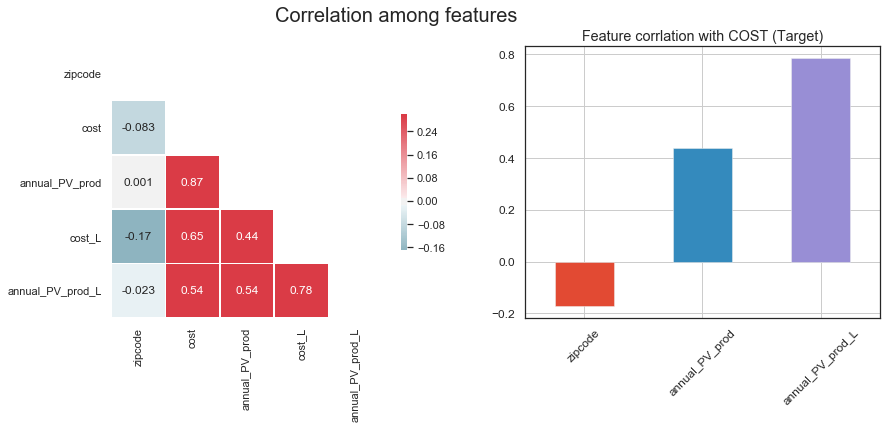

In [10]:
# Correlation matrix among all features will inform us relationship between features
sns.set(style='white', font_scale = 1)
fig, axes = plt.subplots(1,2, figsize = (14,5))
# Correlation matrix
corr = solar.corr().round(3)
# Generate mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig.suptitle('Correlation among features', x=0.42, y=.99, fontsize = 20)

# Generate custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, annot_kws={'size': 12}, mask=mask, cmap=cmap, vmax=.3, 
                                    center=0, square=True, 
            linewidths=.5, cbar_kws={'shrink':.5}, ax=axes[0])
# EDA: Correlation with target
plt.style.use('ggplot')
solar2 = solar.drop(columns=['cost', 'cost_L']) #, 'annual_PV_prod_L'
solar2.corrwith(solar['cost_L']).plot.bar(title = 'Feature corrlation with COST (Target)',
                                               fontsize = 12, rot = 45,ax=axes[1]);

♦ **Initial observation:** <br>
→ As expected `cost_L` and `annual_PV_prod_L` are highly correlated. <br>

# 3. Predictive Modeling

In [11]:
# dependent variable 
y_L = solar['cost_L']
y_val_L = solar_val['cost_L']
# independent variables
solar = solar.drop(columns=['cost', 'cost_L', 'zipcode', 'annual_PV_prod']) 
solar_val = solar_val.drop(columns=['cost', 'cost_L', 'zipcode', 'annual_PV_prod' ])                       
solar.shape,y_L.shape, solar_val.shape, y_val_L.shape

((390260, 9), (390260,), (97566, 9), (97566,))

### Machine Learning Pipeline

#### **Making a PIPELINE with BOTH NUMERIC and CATEGORICAL columns separately**<br>
**STEPS**:
* `ColumnTransformer` will be used to create two pipelines that transform the numeric and categorical features separately. 
* We then create another pipeline hooking up this pipeline with a machine learning model.

In [12]:
# Separate into numerical and categorical columns
num_col = solar.select_dtypes('number').columns.tolist()
print(f'Numeric columns are: {num_col}','\n')
cat_col = solar.select_dtypes('object').columns.tolist()
print(f'Categorical columns are: {cat_col}')

Numeric columns are: ['annual_PV_prod_L'] 

Categorical columns are: ['state', 'installer', 'city', 'tech_1', 'county', 'zipcode_1', 'year']


In [13]:
# categorical column has missing values, that will be imputed by 'missing'
print(solar[num_col].isna().sum().sum())
solar[cat_col].isna().mean().round(2)

0


state        0.00
installer    0.13
city         0.00
tech_1       0.22
county       0.00
zipcode_1    0.00
year         0.00
dtype: float64

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [15]:
# Numeric column pipeline
#si = SimpleImputer(strategy='median')
ss = StandardScaler()
steps = [('scale', ss)] #('impute', si), 
numeric_pipe = Pipeline(steps)

# Categorical column pipeline
si = SimpleImputer(strategy='constant', fill_value='UNKNOWN')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
steps = [('impute', si), ('ohe', ohe)]
cat_pipe = Pipeline(steps)

# Transform both Numeric and Categorical columns
transformers = [('numeric_pipe', numeric_pipe, num_col), ('cat_pipe', cat_pipe, cat_col)]
ct = ColumnTransformer(transformers)
# Save transformed data
X = ct.fit_transform(solar)

#Put ML in the final pipeline
rg = Ridge(alpha=1)
final_pipe = Pipeline([('ct', ct), ('rg', rg)])

# Performance without hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(final_pipe, solar, y_L, cv=kf)
print(f'Ridge regression performance without hyperparameter tuning')
print(f'cross-val score_R2: {cv_scores.mean().round(4)}, standard deviation: {cv_scores.std().round(6)}')

# Performance with validation set
cv_scores = cross_val_score(final_pipe, solar_val, y_val_L, cv=kf)
print(f'Validation set cross-val score_R2: {cv_scores.mean().round(4)}, standard deviation: {cv_scores.std().round(6)}')

Ridge regression performance without hyperparameter tuning
cross-val score_R2: 0.8005, standard deviation: 0.001203
Validation set cross-val score_R2: 0.8006, standard deviation: 0.002045


**Let's try to improve R2 by hyperparameter tuning**
We can grid search with a pipeline object as well. We need to precede the parameter value one would like to tune by two underscores and the name of the step. For instance, to tune the strategy parameter of the imputer, you must use the name (IMPUTE), thus it will be impute__strategy

In [16]:
grid = {'rg__alpha': np.logspace(-3, 3, 1000)} 
gs = GridSearchCV(final_pipe, grid, cv=kf)
gs.fit(solar, y_L)
print(f'Ridge regression performance after hyperparameter tuning')
print(f'best_score: {(gs.best_score_).round(6)}')
ridge_best_alpha = gs.best_params_['rg__alpha']
print(f'ridge_best_alpha: {ridge_best_alpha.round(6)}')

# Regularized regression(lasso) after tuning
rg = Ridge(alpha = ridge_best_alpha)
final_pipe = Pipeline([('ct', ct), ('rg', rg)])

# Performance with hyperparameter tuning
cv_scores = cross_val_score(final_pipe, solar, y_L, cv=kf)
print(f'cross-val score_R2: {cv_scores.mean().round(4)}, standard deviation: {cv_scores.std().round(6)}')

# Peformance with validation set 
cv_scores = cross_val_score(final_pipe, solar_val, y_val_L, cv=kf)
print(f'Validation set cross-val score_R2: {cv_scores.mean().round(4)}, standard deviation: {cv_scores.std().round(6)}')

Ridge regression performance after hyperparameter tuning
best_score: 0.800521
ridge_best_alpha: 4.126821
cross-val score_R2: 0.8005, standard deviation: 0.001204
Validation set cross-val score_R2: 0.8006, standard deviation: 0.002051


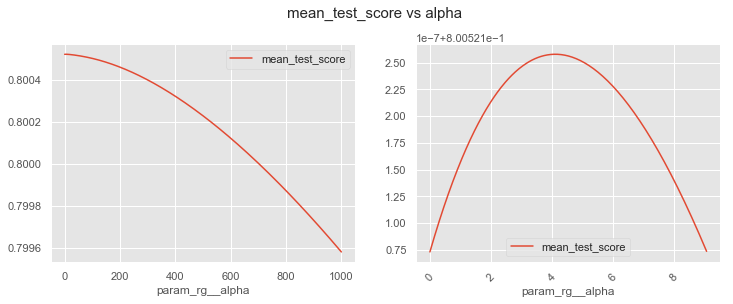

In [17]:
# Plot to show how alpha(penalty) impacts model performance
df_results = pd.DataFrame(gs.cv_results_)
fig, axes = plt.subplots(1,2, figsize = (12,4))
df_results.plot(x='param_rg__alpha', y='mean_test_score', ax=axes[0])
df_results[:660].plot(x='param_rg__alpha', y='mean_test_score', ax=axes[1]) 
axes[1].xaxis.set_tick_params(rotation=45)
fig.suptitle('mean_test_score vs alpha', fontsize=15, y=1.01);

As penalty increases (upto around 4.2) performance improves and after that with stronger penalty, performance reduces due to weight of the penalty.

**Overall summary**<br>
■ We built the ML pipeline with ridge regression and it performed with a R2 of 80%, CV showed limited standard deviation.<br>
■ In part 3 of the notebook we will focus on conceiving a data-product idea, where an user can give his energy usage and his/her location (zipcode, county, city etc) to get predicted size of solar panels needed, and predicted cost of the solar panels.